# Black Jack with Monte Carlo
In this task you are asked to find an optimal policy for a Black Jack game. You are going to use an OpenAI Gym [Black Jack environment](https://gym.openai.com/envs/Blackjack-v0/) in this task. [OpenAI Gym](https://gym.openai.com/) is a toolkit for developing and comparing reinforcement learning algorithms. One of its features is to provide various RL-ready environments to facilitate studing and developing new Reinforcement Learning algorithms.

The main purposes of this notebook are to introduce:
- OpenAI Gym environments
- Monte Calro Methods
- the `Exploring starts` exploration algorithm 




In [1]:
#!pip install gym
#!pip install pygame

In [1]:
import gym 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm

### Black Jack Environment
- `states` - are provided as tuples (`score`, `dealer score`, `useable ace`)
    - `score` - the summary score of your cards (4-21)
    - `dealer score` - the first dealer card (1-10)
    - `useable ace` - True/False, points out if you have a useable ace
- `actions`
    - `0` - draw
    - `1` - hit
- `rewards`
    - `1` - you won a game
    - `0` - draw
    - `-1` - you lost a game
    
    
Let's create an environment and see how to use it.

In [2]:
env = gym.make('Blackjack-v1')
state = env.reset()
print (f'Initial state: {state}.')

Initial state: (8, 10, False).


In [3]:
def sample_policy(state):
    score, dealer_score, usable_ace = state
    return 0 if score >= 19 else 1

state = env.reset()
print (f'Initial state: {state}.')
terminal = False

while not terminal:
    action = sample_policy(state)
    
    next_state, reward, terminal, info = env.step(action)
    print (f'State: {state}, Action: {action}, reward: {reward}, terminal: {terminal}')
    
    state = next_state
    
print (f'Terminal state: {state}, Final reward: {reward}')

Initial state: (14, 4, False).
State: (14, 4, False), Action: 1, reward: 0.0, terminal: False
State: (20, 4, False), Action: 0, reward: 1.0, terminal: True
Terminal state: (20, 4, False), Final reward: 1.0


## Task 1
Fill in the placeholders to complete the `update_qest` method.  You are supposed
to compute an updated state-action value according to the formula:


$q_{n+1} = q_{n} + \frac{1}{n}(G_n-q_n)$

where:
- $q_{n}$ - current estimated state-action value 
- $q_{n+1}$ - new estimated state-action value 
- $G_n$ - return obtained for the explored state and action
- $n$ - number of actions (computed separately for each action type)

In [4]:
class Policy:
    """
    This class is used to learn and maintain the policy. It is being done by
    learning action-value methods. 
    Properties: 
        q_est - a dictionary that stores estimated state-action values for 
                the states
                { state : [value for action0, value for action1] }
        n     - a dictionary that stores how many times each state-action 
                value was updated
                { state : [no. updates for action0, no. updates for action 1]}
    Methods:
        act         - returns a greedy action according to a current policy.
                      The initial policy assumes to hit until the score >= 19.
                      Then it is gradually updated in a learning process
        update_qest - updates a specific state-action value using a given 
                      return
        plot        - visualizes the policy.
    """
    
    def __init__(self):
        
        # Dictionary with { state : [state action value for 0, state action value for 1]  }
        self.q_est = {}        
        self.n = {}
        
    def __initialize_state(self, state):
        if state in self.q_est:
            return

        score = state[0]
        should_hit = int (score < 19)
        self.q_est[state] = [1 - should_hit, should_hit]
        self.n[state] = [0, 0]
        
        
    def act(self, state):
        """
        Returns a greedy action according to the current policy
        Arguments:
            state - a state obtained from OpenAI Gym Black Jack environment
        Returns:
            action - 0 for 'draw', 1 for 'hit'
        """
        self.__initialize_state(state)
        return np.argmax(self.q_est[state])
                
    def update_qest(self, state, action, g):
        """
        Updates state-action value for a specific state and a specific action.
        State-action values are computed as a mean of all returns
        Arguments:
            state  - a state obtained from OpenAI Gym Black Jack environment
            action - 0 for 'draw', 1 for 'hit'
            g      - return that should be used for updating        
        """
        self.__initialize_state(state)
        
        # ENTER YOUR CODE HERE. 
        self.n[state][action]= self.n[state][action]+1
        self.q_est[state][action] = self.q_est[state][action]+((1.0/(self.n[state][action]))*(g-self.q_est[state][action]))
        
        # END OF YOUR CODE
        
    def plot(self, useable_ace = True):
        """
        Plots a visualization of current policy. It plots the policy only for the explored
        states. The states that haven't been explored yet, are plotted as 'unknown'
        Arguments:
            useable_ace - True / False. It plots different policies, whether the player
                          has or does not have a useable ace.        
        """
        states = [x for x in policy.q_est.keys() if x[2] == useable_ace]
        rows = max(x[0] for x in states)
        cols = max(x[1] for x in states)
        
        res = -1 * np.ones((rows, cols))
        for state in states:
            res[rows-state[0], state[1]-1] = self.act(state)
            
        fig = plt.figure(figsize = (12, 8))

        #cbar_kws = {'ticks' : [0, 0.5, 1]}
        cmap = matplotlib.colors.ListedColormap(('white', 'r', 'g'), name = 'My Cmap')

        ax = sns.heatmap(res, linewidth=0.5, cmap = cmap)
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([1, 0, -1])
        cbar.set_ticklabels(['hit', 'draw', 'unknown'])
        ax.set_xticks(np.arange(10) + 1)
        ticks = np.arange(10)
        xticklabels = [f'       {x}' for x in list(ticks+1)]

        plt.xticks(ticks, xticklabels, ha = 'left')
        ticks = np.arange(21)
        yticklabels = [f'{x} ' + (' ' if x < 10 else '') for x in list(ticks+1)[::-1]]
        plt.yticks(ticks, yticklabels, rotation=90, va='top')
        plt.title('Black Jack policy with' + ('' if useable_ace else 'out') + ' a useable ace')

        plt.show()        


## Task 2
Complete the generate_episode function by filling in the code placeholders
You are supposed to:
- randomly select the initial action and execute this action 
- select every other action according to the policy and execute it
- update policy for each state-action pair generated during the episode

In [5]:
def generate_episode(policy):
    """
    Generates one episode, and updates state-action values of the policy
    acording to the 
    """
    states = []
    actions = []
    
    state = env.reset()
    
    # ENTER YOUR CODE HERE
    # Choose the first action randomly
    action = np.random.randint(0,2)
    # END OF YOUR CODE
    
    states.append(state)
    actions.append(action)
    
    # ENTER YOUR CODE HERE
    # Execute the action you chose above
    state, reward, terminal, info = env.step(action)
    # END OF YOUR CODE
    
    while not terminal:
        # ENTER YOUR CODE HERE
        # Choose an action according to the current policy
        action = policy.act(state)
        # END OF YOUR CODE
        
        states.append(state)
        actions.append(action)
                
        # ENTER YOUR CODE HERE
        # Execute the action you chose above
        state, reward, terminal, info = env.step(action)
        # END OF YOUR CODE
        
    for state, action in zip(states, actions):
        # ENTER YOUR CODE HERE
        # Update qest
        
        # END OF YOUR CODE
        policy.update_qest(state, action, reward)
        
    

## Task 3
Generate episodes and learn from them until you learn the optimal policy. You may use `policy.plot()` to visualize your policies.

In [15]:
# ENTER YOUR CODE HERE
# Generate enough episodes to obtain the optimal policy
policy = Policy()
for i in tqdm(range (2000000)):
    generate_episode(policy)


100%|██████████| 2000000/2000000 [18:53<00:00, 1763.70it/s]


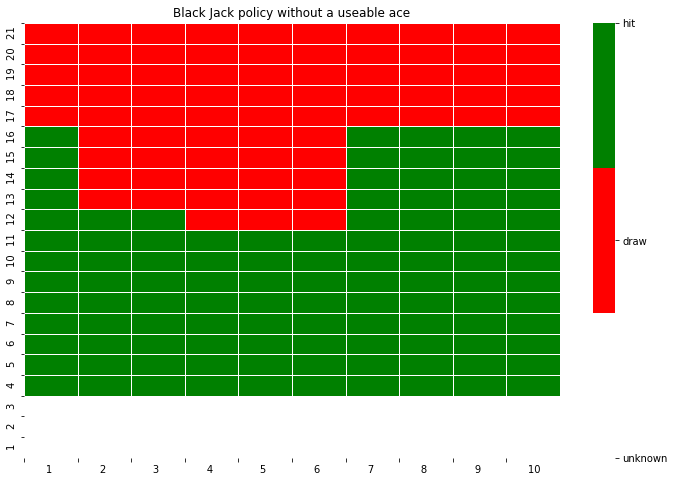

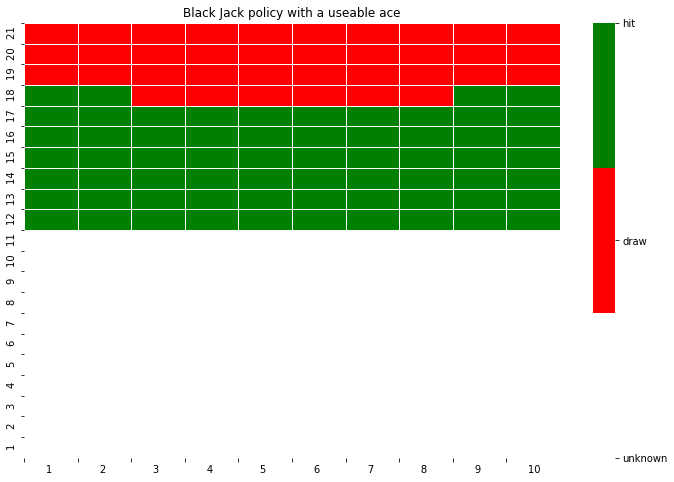

In [16]:
policy.plot(False)
policy.plot(True)

In [17]:
keys = list(policy.q_est.keys())

In [18]:
print(policy.q_est)

{(19, 6, False): [0.5100900695473738, -0.7159340659340655], (13, 7, False): [-0.47948677332488565, -0.2442019099590727], (13, 7, True): [-0.484633569739953, 0.1779141104294479], (12, 7, False): [-0.4618913719106124, -0.21126912303382892], (19, 3, True): [0.3906056860321381, 0.18435155412647386], (18, 5, True): [0.2173624917163687, 0.14413407821229052], (21, 9, False): [0.9390567707674804, 0], (11, 9, False): [-0.5439455782312925, 0.1777827347758193], (14, 4, False): [-0.22650800164136278, -0.3189898654261512], (8, 4, False): [-0.23899102180418957, 0.021407986825854278], (20, 10, False): [0.43620204309261573, -0.8572214580467677], (21, 10, True): [0.9157640130402781, 0.06293366638912055], (13, 10, False): [-0.5706272310045909, -0.4612472449111877], (14, 5, False): [-0.16524275890810605, -0.3307204803202142], (21, 10, False): [0.8881547448051317, 0], (18, 2, False): [0.13115949578081065, -0.6207810993249727], (14, 2, False): [-0.2927024859663186, -0.34791977457317985], (17, 1, False): [-